# CS4320 Introduction to Machine Learning

## A Template for the Course Project Submssion

Note: This template is optional. You can design your Jupyter Notebook structure based on your competition and preference. However, we expect you practice as many machine learning skills you learned in this course as possible.

**Please type your group name here:**

In [1]:
GroupName = "PSW"
assert GroupName != "", 'Please enter your name in the above quotation marks, thanks!'
GroupMembers = "Spencer Potter, Ben Smith, Carter Watson"

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5)
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11)
12. [Results on the test set](#12)
13. [Submit the predictions to Kaggle](#13)
14. [Your takeaway from the course](#14)

## Submission instructions <a name="si"></a>
<hr>

- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline.
- Upload the .ipynb file to Canvas.
- **Submit the screenshot of your Kaggle submission ranking and score**
- Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
- Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
- Make sure that the plots and output are rendered properly in your submitted file.
- Please keep your notebook clean and delete any throwaway code.

## Introduction <a name="in"></a>

A few notes and tips when you work on this project:

#### Tips
1. The project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary.
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code.
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions.

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


<br><br>

<!-- BEGIN QUESTION -->

## 1. Store Sales Time Series Forecasting <a name="1"></a>
[Kaggle Data](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)
<hr>



**Problem Explanation:** \
For this problem we will be looking at the total sales of multiple different items from all of the different store locations. We have multiple different features that will help us determine and predict how each item will sale on every given day of the year and at each location. The stores want this information so they can accurately order enough of each item throughout the year.

**Features:** \
*Train file* \
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.\
store_nbr identifies the store at which the products are sold. \
family identifies the type of product sold.\
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).\
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

*Test file*\
This has the same features as the train file, we want to predict the sales for this file.\

*Store File* \
Store metadata, including city, state, type, and cluster.\
cluster is a grouping of similar stores.\

*Oil File* \
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

*Holiday Events File* \
Holidays and Events, with metadata\




**Imports**

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

**Introducing the DataSet**

In [3]:
train_df=pd.read_csv("needed_data/train.csv")
print(train_df.shape)
test_df=pd.read_csv("needed_data/test.csv")
print(test_df.shape)
train_df.describe()

(3000888, 6)
(28512, 5)


id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02

In [4]:
holiday_df = pd.read_csv("needed_data/holidays_events.csv")
oil_df = pd.read_csv("needed_data/oil.csv")
stores_df = pd.read_csv("needed_data/stores.csv")
transactions_df = pd.read_csv("needed_data/transactions.csv")

train_df = pd.merge(train_df, holiday_df, on='date', how='left')
train_df = pd.merge(train_df, oil_df, on='date', how='left')
train_df = pd.merge(train_df, stores_df, on='store_nbr', how='left')
train_df = pd.merge(train_df, transactions_df, on=['date', 'store_nbr'], how='left')

test_df = pd.merge(test_df, holiday_df, on='date', how='left')
test_df = pd.merge(test_df, oil_df, on='date', how='left')
test_df = pd.merge(test_df, stores_df, on='store_nbr', how='left')
test_df = pd.merge(test_df, transactions_df, on=['date', 'store_nbr'], how='left')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   type_x        object 
 7   locale        object 
 8   locale_name   object 
 9   description   object 
 10  transferred   object 
 11  dcoilwtico    float64
 12  city          object 
 13  state         object 
 14  type_y        object 
 15  cluster       int64  
 16  transactions  float64
dtypes: float64(3), int64(4), object(10)
memory usage: 396.1+ MB


<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>

**Your tasks:**

1. Split the data into train and test portions.

In [5]:
x_train = train_df.loc[:, train_df.columns != 'sales']
y_train = train_df['sales'].fillna(0)
x_test = test_df.loc[:, test_df.columns != 'sales']

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data.

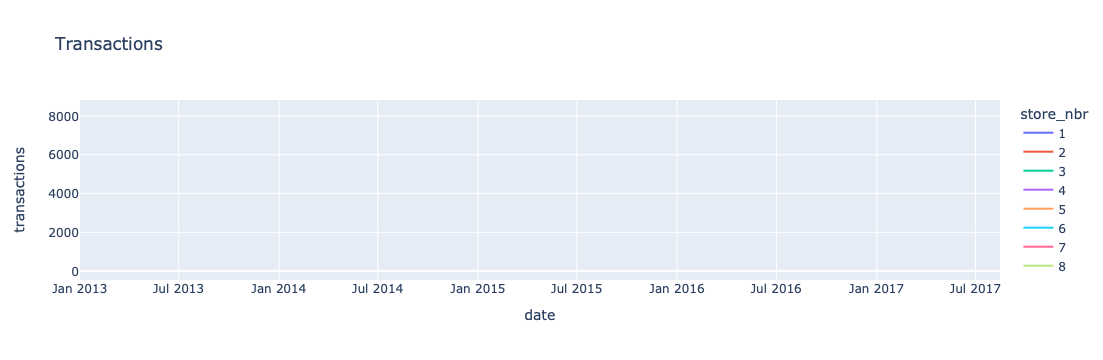

In [6]:
train_temp = train_df

px.line(transactions_df.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )

<Axes: xlabel='date'>

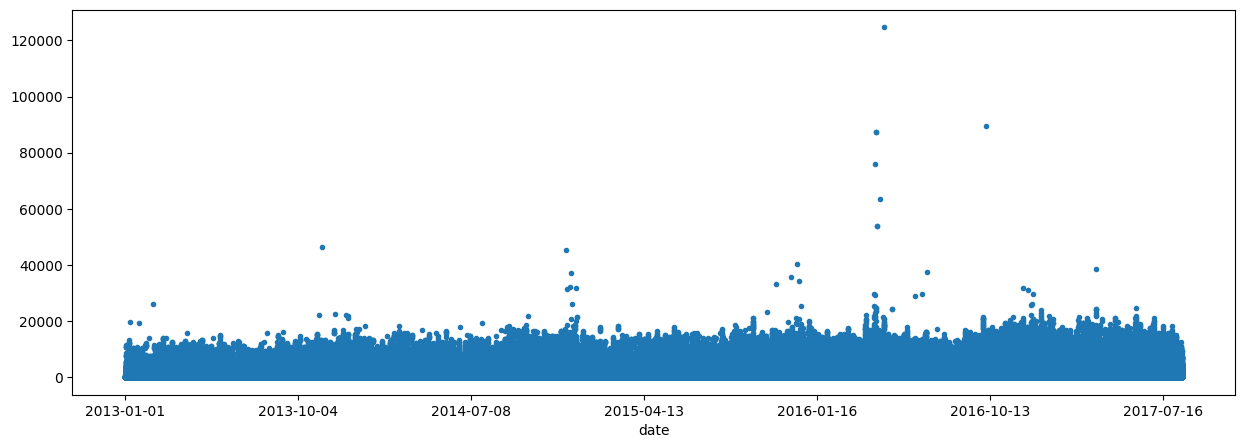

In [7]:
train_df=train_df.set_index("date")
train_df['sales'].plot(style='.', figsize=(15,5))

Looking at this plot of the sales of items from 2013 to 2017 we see that the data is fairly linear with a few outliers

<Axes: xlabel='date'>

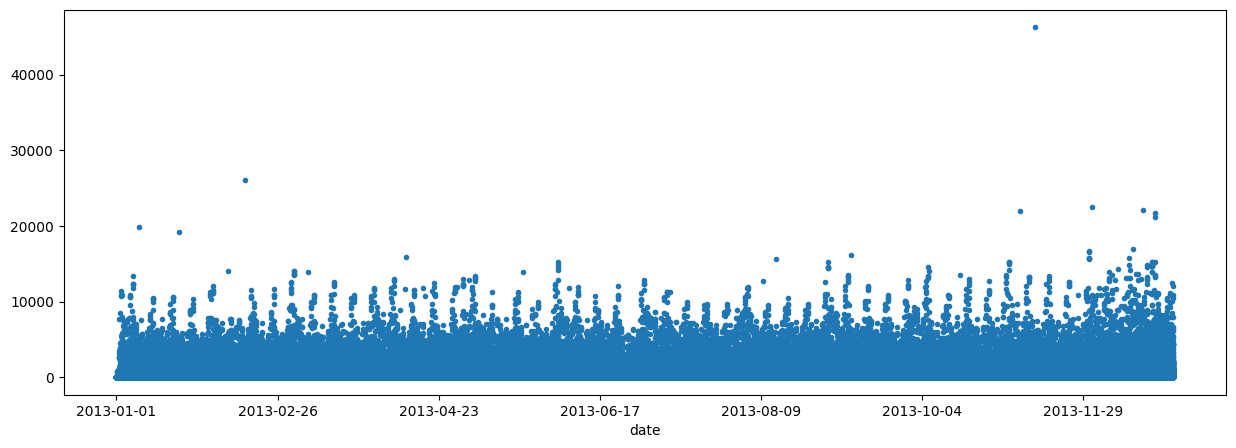

In [8]:
start_date = '2013-01-01'
end_date = '2013-12-30'
df_filtered = train_df.loc[start_date:end_date]

# Plot only the 'sales' column for the selected date range
df_filtered['sales'].plot(style='.', figsize=(15, 5))

Here we are only looking at the sales for one year. This shows us that there is clearly times within the month were overall more products will sell

<Axes: xlabel='date'>

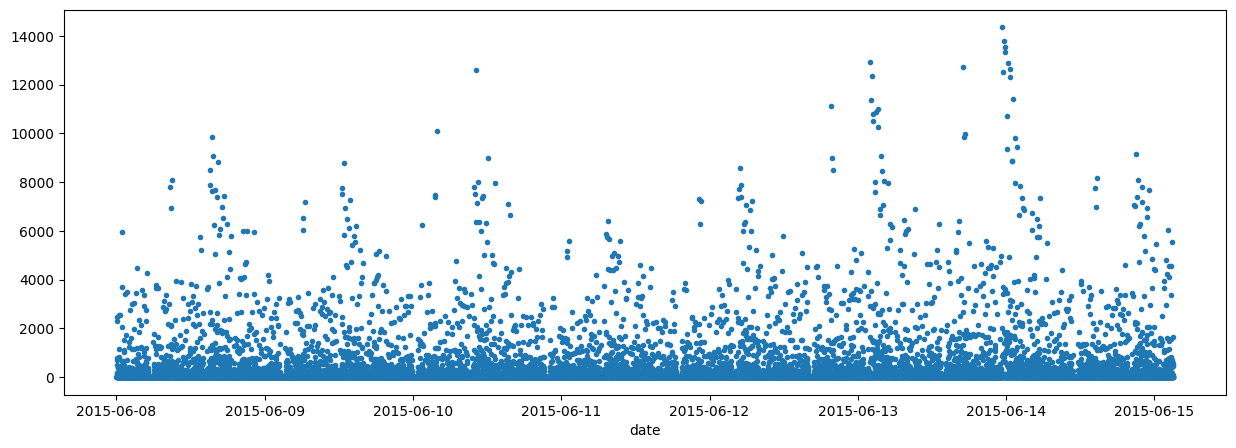

In [9]:
start_date = '2015-06-08'
end_date = '2015-06-15'
df_filtered = train_df.loc[start_date:end_date]
df_filtered['sales'].plot(style='.', figsize=(15, 5))

Based on the sales over a year and a week, we can see that there are more sales 1) In November and December, 2) on the weekends, and 3) in the evenings.

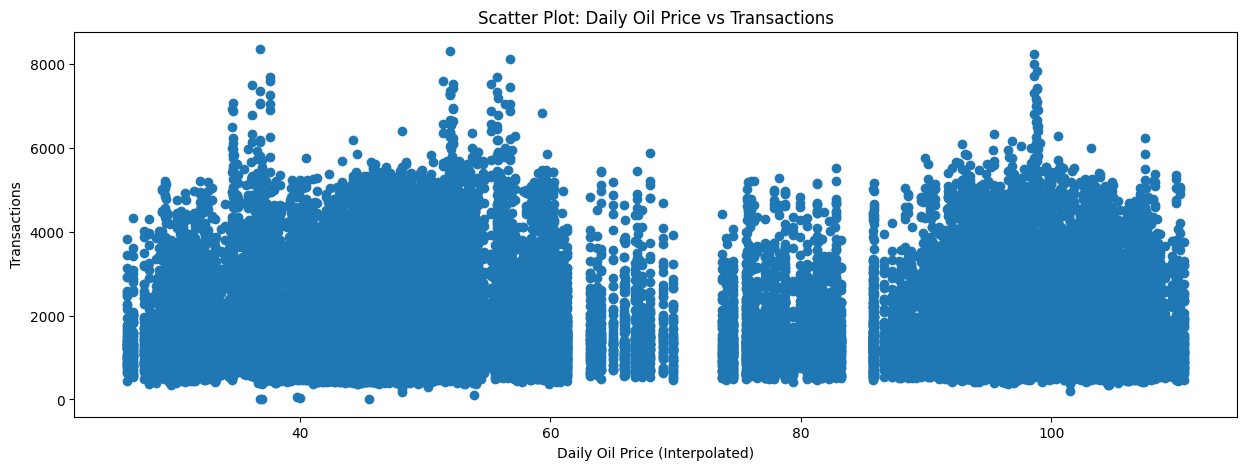

Text(0.5, 1.0, 'Scatter Plot: Daily Oil Price vs Sales')

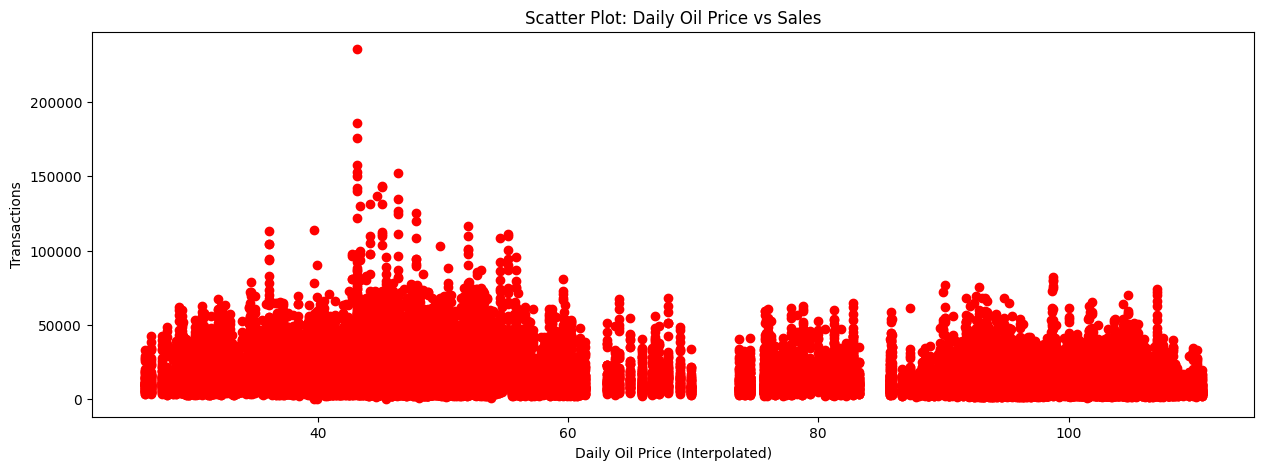

In [10]:
oil = oil_df
transactions = transactions_df

oil['ma_oil'] = oil['dcoilwtico'].rolling(7).mean()
oil["date"] = pd.to_datetime(oil.date)
transactions["date"] = pd.to_datetime(transactions.date)
train_temp["date"] = pd.to_datetime(train_temp.date)

# Resample
oil = oil_df.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')

temp = pd.merge(oil, transactions, on='date', how = "left")
temp = pd.merge(temp, train_temp.groupby(["date", "store_nbr"]).sales.sum().reset_index(), how='left')

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Assuming temp is your DataFrame
axes.scatter(temp['dcoilwtico_interpolated'], temp['transactions'])
axes.set_xlabel('Daily Oil Price (Interpolated)')
axes.set_ylabel('Transactions')
axes.set_title('Scatter Plot: Daily Oil Price vs Transactions')

plt.show()

temp2 = pd.merge(train_temp.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
temp2['date'] = pd.to_datetime(temp2['date'].astype(str))
temp2 = pd.merge(temp2, oil, how = "left")

fig, axes = plt.subplots(1, 1, figsize = (15,5))
axes.scatter(temp['dcoilwtico_interpolated'], temp['sales'], color='red')
axes.set_xlabel('Daily Oil Price (Interpolated)')
axes.set_ylabel('Transactions')
axes.set_title('Scatter Plot: Daily Oil Price vs Sales')

The Kaggle competition emphasized that Ecuador is a country that relies heavily on the oil economy. We can see that oil price and transactions are correlated.

In [11]:
train_df.sort_index()
train_df.set_index('id')
test_df.sort_index()
test_df.set_index('id')

x_train['date'] = pd.to_datetime(x_train['date'])
x_test['date'] = pd.to_datetime(x_test['date'])

x_train['year'] = x_train['date'].dt.year
x_train['month'] = x_train['date'].dt.month
x_train['day'] = x_train['date'].dt.day
x_train['day_of_week'] = x_train['date'].dt.dayofweek
x_train['week_of_year'] = x_train['date'].dt.isocalendar().week
x_train['day_of_year'] = x_train['date'].dt.dayofyear

x_test['year'] = x_test['date'].dt.year
x_test['month'] = x_test['date'].dt.month
x_test['day'] = x_test['date'].dt.day
x_test['day_of_week'] = x_test['date'].dt.dayofweek
x_test['week_of_year'] = x_test['date'].dt.isocalendar().week
x_test['day_of_year'] = x_test['date'].dt.dayofyear

/var/folders/g8/nk546p356gg5p0v0bn18pq240000gn/T/ipykernel_6308/2815827004.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set. You may have to go back and forth between feature engineering and preprocessing. Briefly explain why you come up with these new features.

In [12]:
# Creating lag features for the 'onpromotion' column for the past 3 days
for lag in range(1, 4):  # 3 lags
    x_train[f"onpromotion_lag_{lag}"] = x_train["onpromotion"].shift(lag)

# Creating rolling window average and sum for the 'onpromotion' column for the past 7 days
x_train["onpromotion_rolling_avg_7"] = x_train["onpromotion"].rolling(window=7).mean()
x_train["onpromotion_rolling_sum_7"] = x_train["onpromotion"].rolling(window=7).sum()

# Compute rate of change with a check for zero in the denominator
denominator = x_train["onpromotion"].shift()
numerator = x_train["onpromotion"].diff()
x_train["onpromotion_rate_of_change"] = np.where(denominator != 0, numerator / denominator, 0)

# Clean NaN's from data, replace with 0
lag_and_window_columns = [col for col in x_train.columns if col.startswith("onpromotion_")]
x_train[lag_and_window_columns] = x_train[lag_and_window_columns].fillna(0)

# Display the first few rows to inspect the newly created features
x_train.head(1135137)  # Displaying 1135137 rows to better see the populated rolling features (rare to see non zero/NaN values in the first few rows)

# paydays are on the 15th and last day of the month
# add days since last payday
x_train['days_since_last_payday'] = np.where(x_train['day'] <= 15,
                                             x_train['day'] - 1,
                                             x_train['day'] - 16)

# boolean for whether the date is a weekend
x_train['is_weekend'] = (pd.to_datetime(x_train['date']).dt.dayofweek >= 5).astype(int)

# Display the first few rows to inspect the feature
x_train[['date', 'days_since_last_payday', 'is_weekend']].drop_duplicates().head(20)  # Display unique dates for better visibility


# Creating lag features for the 'onpromotion' column for the past 3 days
for lag in range(1, 4):  # 3 lags
    x_test[f"onpromotion_lag_{lag}"] = x_test["onpromotion"].shift(lag)

# Creating rolling window average and sum for the 'onpromotion' column for the past 7 days
x_test["onpromotion_rolling_avg_7"] = x_test["onpromotion"].rolling(window=7).mean()
x_test["onpromotion_rolling_sum_7"] = x_test["onpromotion"].rolling(window=7).sum()

# Compute rate of change with a check for zero in the denominator
denominator = x_test["onpromotion"].shift()
numerator = x_test["onpromotion"].diff()
x_test["onpromotion_rate_of_change"] = np.where(denominator != 0, numerator / denominator, 0)

# Clean NaN's from data, replace with 0
lag_and_window_columns = [col for col in x_test.columns if col.startswith("onpromotion_")]
x_test[lag_and_window_columns] = x_test[lag_and_window_columns].fillna(0)

# add days since last payday
x_test['days_since_last_payday'] = np.where(pd.to_datetime(x_test['date']).dt.day <= 15,
                                             pd.to_datetime(x_test['date']).dt.day - 1,
                                             pd.to_datetime(x_test['date']).dt.day - 16)

# boolean for whether the date is a weekend
x_test['is_weekend'] = (pd.to_datetime(x_test['date']).dt.dayofweek >= 5).astype(int)

# Display the first few rows to inspect the feature
x_test[['date', 'days_since_last_payday', 'is_weekend']].drop_duplicates().head(20)  # Display unique dates for better visibility


date  days_since_last_payday  is_weekend
0     2017-08-16                       0           0
1782  2017-08-17                       1           0
3564  2017-08-18                       2           0
5346  2017-08-19                       3           1
7128  2017-08-20                       4           1
8910  2017-08-21                       5           0
10692 2017-08-22                       6           0
12474 2017-08-23                       7           0
14256 2017-08-24                       8           0
16038 2017-08-25                       9           0
17820 2017-08-26                      10           1
19602 2017-08-27                      11           1
21384 2017-08-28                      12           0
23166 2017-08-29                      13           0
24948 2017-08-30                      14           0
26730 2017-08-31                      15           0

In [13]:
print(x_train.columns)
print(x_test.columns)
x_test.dtypes

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'type_x', 'locale',
       'locale_name', 'description', 'transferred', 'dcoilwtico', 'city',
       'state', 'type_y', 'cluster', 'transactions', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'day_of_year', 'onpromotion_lag_1',
       'onpromotion_lag_2', 'onpromotion_lag_3', 'onpromotion_rolling_avg_7',
       'onpromotion_rolling_sum_7', 'onpromotion_rate_of_change',
       'days_since_last_payday', 'is_weekend'],
      dtype='object')
Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'type_x', 'locale',
       'locale_name', 'description', 'transferred', 'dcoilwtico', 'city',
       'state', 'type_y', 'cluster', 'transactions', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'day_of_year', 'onpromotion_lag_1',
       'onpromotion_lag_2', 'onpromotion_lag_3', 'onpromotion_rolling_avg_7',
       'onpromotion_rolling_sum_7', 'onpromotion_rate_of_change',
       'days_since_last_payday', '

id                                     int64
date                          datetime64[ns]
store_nbr                              int64
family                                object
onpromotion                            int64
type_x                                object
locale                                object
locale_name                           object
description                           object
transferred                           object
dcoilwtico                           float64
city                                  object
state                                 object
type_y                                object
cluster                                int64
transactions                         float64
year                                   int32
month                                  int32
day                                    int32
day_of_week                            int32
week_of_year                          UInt32
day_of_year                            int32
onpromotio

In [14]:
print(x_test.isna())
numeric_features=["onpromotion", "days_since_last_payday", "onpromotion_rolling_avg_7", "onpromotion_rolling_sum_7", "onpromotion_rate_of_change", "dcoilwtico", "cluster", "transactions", "day_of_week", "week_of_year", "day_of_year", "day", "month", "year"]
categorical_features = ["family", "locale_name", "description", "type_x", "type_y"]
passthrough_features=["store_nbr"]
binary_features = ["is_weekend"]
drop_features = ["locale", "transferred", "city", "state", "date", "id"]

          id   date  store_nbr  family  onpromotion  type_x  locale  \
0      False  False      False   False        False    True    True   
1      False  False      False   False        False    True    True   
2      False  False      False   False        False    True    True   
3      False  False      False   False        False    True    True   
4      False  False      False   False        False    True    True   
...      ...    ...        ...     ...          ...     ...     ...   
28507  False  False      False   False        False    True    True   
28508  False  False      False   False        False    True    True   
28509  False  False      False   False        False    True    True   
28510  False  False      False   False        False    True    True   
28511  False  False      False   False        False    True    True   

       locale_name  description  transferred  ...  week_of_year  day_of_year  \
0             True         True         True  ...         False    

In [15]:
for i in range(1, 4):
    numeric_features.append(f"onpromotion_lag_{i}")

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type.
2. Define a column transformer, if necessary.

In [16]:
for column in x_train.columns:
    if column in drop_features and not 'id':
        x_train = x_train.drop(column, axis=1)

for column in x_test.columns:
    if column in drop_features and not 'id':
        x_test = x_test.drop(column, axis=1)

In [17]:
x_train.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'type_x', 'locale',
       'locale_name', 'description', 'transferred', 'dcoilwtico', 'city',
       'state', 'type_y', 'cluster', 'transactions', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'day_of_year', 'onpromotion_lag_1',
       'onpromotion_lag_2', 'onpromotion_lag_3', 'onpromotion_rolling_avg_7',
       'onpromotion_rolling_sum_7', 'onpromotion_rate_of_change',
       'days_since_last_payday', 'is_weekend'],
      dtype='object')

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assuming you have defined your numeric, categorical, and binary features

# Numeric transformer
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', MinMaxScaler())  # Apply min-max scaling
])

# Categorical transformer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

# Binary transformer
binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent category
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features),
        ('drop', 'drop', drop_features)
    ],
    remainder='passthrough'
)

# Fit-transform on the training set
x_train_transformed = preprocessor.fit_transform(x_train)
x_test_transformed = preprocessor.fit_transform(x_test)

# Extract feature names after transformation
transformed_column_names = preprocessor.get_feature_names_out()

# Set the categories for OneHotEncoder in the categorical_transformer
categorical_transformer.named_steps['onehot'].categories_ = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/impute/_base.py:555: UserWarning:

Skipping features without any observed values: ['transactions']. At least one non-missing value is needed for imputation with strategy='median'.



<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

**Dummy Model**

In [19]:
import warnings
baseline_model = make_pipeline(preprocessor, DummyRegressor(strategy='mean'))
warnings.filterwarnings("ignore")

In [20]:
results_dict = {}

In [21]:
scores = cross_val_score(baseline_model, x_train, y_train, cv=5)
results_dict['cross_val_scores'] = -scores
results_df = pd.DataFrame(results_dict)
print(np.mean(results_df))

#Because we're using the dummy regressor, smaller values mean better accuracy

0.018344256879617937


In [22]:
print(x_test.columns)
x_test.isna()

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'type_x', 'locale',
       'locale_name', 'description', 'transferred', 'dcoilwtico', 'city',
       'state', 'type_y', 'cluster', 'transactions', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'day_of_year', 'onpromotion_lag_1',
       'onpromotion_lag_2', 'onpromotion_lag_3', 'onpromotion_rolling_avg_7',
       'onpromotion_rolling_sum_7', 'onpromotion_rate_of_change',
       'days_since_last_payday', 'is_weekend'],
      dtype='object')


id   date  store_nbr  family  onpromotion  type_x  locale  \
0      False  False      False   False        False    True    True   
1      False  False      False   False        False    True    True   
2      False  False      False   False        False    True    True   
3      False  False      False   False        False    True    True   
4      False  False      False   False        False    True    True   
...      ...    ...        ...     ...          ...     ...     ...   
28507  False  False      False   False        False    True    True   
28508  False  False      False   False        False    True    True   
28509  False  False      False   False        False    True    True   
28510  False  False      False   False        False    True    True   
28511  False  False      False   False        False    True    True   

       locale_name  description  transferred  ...  week_of_year  day_of_year  \
0             True         True         True  ...         False        False   
1             True         True         True  ...         False        False   
2             True         True         True  ...         False        False   
3             True         True         True  ...         False        False   
4             True         True         True  ...         False        False   
...            ...          ...          ...  ...           ...          ...   
28507         True         True         True  ...         False        False   
28508         True         True         True  ...         False        False   
28509         True         True         True  ...         False        False   
28510         True         True         True  ...         False        False   
28511         True         True         True  ...         False        False   

       onpromotion_lag_1  onpromotion_lag_2  onpromotion_lag_3  \
0                  False              False              False   
1                  False              False              False   
2                  False              False              False   
3                  False              False              False   
4                  False              False              False   
...                  ...                ...                ...   
28507              False              False              False   
28508              False              False              False   
28509              False              False              False   
28510              False              False              False   
28511              False              False              False   

       onpromotion_rolling_avg_7  onpromotion_rolling_sum_7  \
0                          False                      False   
1                          False                      False   
2                          False                      False   
3                          False                      False   
4                          False                      False   
...                          ...                        ...   
28507                      False                      False   
28508                      False                      False   
28509                      False                      False   
28510                      False                      False   
28511                      False                      False   

       onpromotion_rate_of_change  days_since_last_payday  is_weekend  
0                           False                   False       False  
1                           False                   False       False  
2                           False                   False       False  
3                           False                   False       False  
4                           False                   False       False  
...                           ...                     ...         ...  
28507                       False                   False       False  
28508                       False                   False       False 

In [23]:
baseline_model.fit(x_train, y_train)
prediction = baseline_model.predict(x_test)
prediction_df = pd.DataFrame({'id': x_test.id, 'sales': prediction})
prediction_df.to_csv("dummy_test_predictions.csv", index=False)

The results from the Dummy Classifier give us a score of 3.39044 on Kaggle when we submit them. This is pretty bad but because it is the dummy classifer we expect it to not be good

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>

**Your tasks:**

1. Try a linear model as a first real attempt.
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter.
3. Report cross-validation scores along with standard deviation.
4. Summarize your results.

**Cross Validation scores without hyperparameter tuning**

In [24]:
from sklearn.linear_model import LinearRegression
lRModel = make_pipeline(preprocessor, LinearRegression())
results_lR_dict = {}
scores = cross_val_score(lRModel, x_train, y_train, cv=5)
results_lR_dict['cross_val_scores'] = scores
results_lR_df = pd.DataFrame(results_lR_dict)
print(np.mean(results_lR_df))

0.5275993630348115


In [25]:
lRModel.fit(x_train, y_train)
lR_prediciton=lRModel.predict(x_test)
lR_prediciton = [max(0, pred) for pred in lR_prediciton]
prediction_df = pd.DataFrame({'id': x_test.id, 'sales': lR_prediciton})
prediction_df.to_csv("linear_regression_test_predictions.csv", index=False)

So Linear Regression doenst have many parameters to tune. When we do tune them the best model ends up being the default that Sklearn uses. With that being said when we submit the test results to kaggle we get a score of 1.66471 which is much better then the dummy score but it still isnt great.

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>

**Your tasks:**
1. Try other models aside from a linear model. One of these models should be a tree-based ensemble model.
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model?

Descision Tree Regression


In [26]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt


In [27]:
dtr = DecisionTreeRegressor(max_depth=5)
DTR_pipeline = make_pipeline(preprocessor, dtr)
results_DTR_dict = {}
scores = cross_val_score(DTR_pipeline, x_train, y_train, cv=5)
results_DTR_dict['cross_val_scores'] = scores
results_DTR_df = pd.DataFrame(results_DTR_dict)
print(results_DTR_df)

   cross_val_scores
0          0.560911
1          0.704935
2          0.688471
3          0.739500
4          0.802658


In [28]:
DTR_pipeline.fit(x_train, y_train)
prediction = DTR_pipeline.predict(x_test)
prediction = [max(0, pred) for pred in prediction]
prediction_df = pd.DataFrame({'id': x_test.id, 'sales': prediction})

prediction_df.to_csv("DTR_predictions.csv", index=False)

*Ridge*

In [29]:
pipeline = make_pipeline(preprocessor, Ridge())
scores = cross_val_score(pipeline, x_train, y_train, cv=5)
print(np.mean(scores))

0.5275935463563779


In [30]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}


# Create a pipeline with Ridge regression
ridge_pipeline = make_pipeline(preprocessor, Ridge())

# Define the parameter distribution for RandomizedSearchCV
param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

# Choose the metric for hyperparameter optimization (e.g., mean squared error)
scoring_metric = 'neg_mean_squared_error'

# Create and fit the RandomizedSearchCV object
random_search = RandomizedSearchCV(ridge_pipeline, param_distributions=param_dist, scoring=scoring_metric, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categorie

Best Hyperparameters: {'ridge__alpha': 0.1767016940294795}


In [32]:
ridge_pipeline.fit(x_train, y_train)
prediction = ridge_pipeline.predict(x_test)
prediction = [max(0, pred) for pred in prediction]
prediction_df = pd.DataFrame({'id': x_test.id, 'sales': prediction})

prediction_df.to_csv("Ridge_test_predictions.csv", index=False)

xgboost model \\
(ensemble  model) \\
For this section we need to rebuild the features that we used before but format them in a way that xgboost can use them. So there is some added features for the xgboost model that werent used before. And there are also features and categories that were used before that arent used now because they hinder the boost model.

We also tune the parameters of the boost. This is why this section takes a long time, because we run through a 1000 iterations of training to get the best boost model. If we ran it through more it could be better but take longer

In [33]:
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
train_df = pd.read_csv('needed_data/train.csv')

# Load testing data
test_df = pd.read_csv('needed_data/test.csv')
df_holidays = pd.read_csv("needed_data/holidays_events.csv")
oil_df = pd.read_csv("needed_data/oil.csv")
stores_df = pd.read_csv("needed_data/stores.csv")
transactions_df = pd.read_csv("needed_data/transactions.csv")

calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))
calendar['dofw'] = calendar.index.dayofweek

#oil manipulation
oil_df['ma_oil'] = oil_df['dcoilwtico'].rolling(7).mean()
calendar = calendar.merge(oil_df, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)

#holidat manipulation
df_holidays['date'] = df_holidays['date'].replace({'2013-04-29' :
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction
df_holidays = df_holidays[df_holidays.locale == 'National'] # National level only for simplicity
df_holidays = df_holidays.groupby(df_holidays.index).first() # Keep one event only

train_df = pd.merge(train_df, df_holidays, on='date', how='left')
train_df = pd.merge(train_df, oil_df, on='date', how='left')
train_df = pd.merge(train_df, stores_df, on='store_nbr', how='left')
train_df = pd.merge(train_df, transactions_df, on=['date', 'store_nbr'], how='left')

test_df = pd.merge(test_df, df_holidays, on='date', how='left')
test_df = pd.merge(test_df, oil_df, on='date', how='left')
test_df = pd.merge(test_df, stores_df, on='store_nbr', how='left')
test_df = pd.merge(test_df, transactions_df, on=['date', 'store_nbr'], how='left')
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Spliting the data and setting up the date feautres
X_train = train_df.drop(columns=['sales'])
y_train = train_df['sales']
X_test = test_df
X_train['year'] = X_train['date'].dt.year
X_train['month'] = X_train['date'].dt.month
X_train['day'] = X_train['date'].dt.day
X_train['day_of_week'] = X_train['date'].dt.dayofweek
X_train['week_of_year'] = X_train['date'].dt.isocalendar().week
X_train['day_of_year'] = X_train['date'].dt.dayofyear

X_test['year'] = X_test['date'].dt.year
X_test['month'] = X_test['date'].dt.month
X_test['day'] = X_test['date'].dt.day
X_test['day_of_week'] = X_test['date'].dt.dayofweek
X_test['week_of_year'] = X_test['date'].dt.isocalendar().week
X_test['day_of_year'] = X_test['date'].dt.dayofyear
###
# Drop the original 'date' column
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.fillna(0, inplace=True)


X_train_encoded = pd.get_dummies(X_train, columns=['family' ], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['family'], drop_first=True)

# List of categorical columns with object dtype
categorical_columns = ['type_x', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'type_y']

# Label encoding for categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_train_encoded[col] = label_encoder.fit_transform(X_train_encoded[col])
    X_test_encoded[col] = label_encoder.transform(X_test_encoded[col])

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded)

# Define XGBoost parameters to tune, the learning rate is what really makes this model great for time series
params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
}

#this will get us the best version of the model
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,  # Adjust the number of folds as needed
    early_stopping_rounds=10,  # Adjust if needed
    verbose_eval=True,
)

# Train the XGBoost model
print(cv_results)

# Get the best number of boosting rounds based on early stopping
best_num_rounds = len(cv_results)
print(f"Best Number of Boosting Rounds: {best_num_rounds}")

# Train the final model with the best number of boosting rounds
final_model = xgb.train(params, dtrain, num_boost_round=best_num_rounds)

# Make predictions on the test set
dtest = xgb.DMatrix(X_test_encoded)
prediction = final_model.predict(dtest)

# Post-process predictions if necessary
prediction = [max(0, pred) for pred in prediction]

# Create a DataFrame with the predictions
prediction_df = pd.DataFrame({'id': X_test.id, 'sales': prediction})

# Save the predictions to a CSV file
prediction_df.to_csv("xgboost_with_cv.csv", index=False)

[0]	train-rmse:1034.54334+3.04386	test-rmse:1034.50402+12.15714
[1]	train-rmse:974.65428+3.06467	test-rmse:974.61094+12.77417
[2]	train-rmse:922.59907+3.24280	test-rmse:922.60663+13.13113
[3]	train-rmse:877.25476+3.31474	test-rmse:877.27094+13.63055
[4]	train-rmse:837.98986+3.36257	test-rmse:838.00233+14.10470
[5]	train-rmse:804.02712+3.43331	test-rmse:804.04106+14.55080
[6]	train-rmse:773.90750+3.53534	test-rmse:773.99770+14.90789
[7]	train-rmse:749.38894+3.75184	test-rmse:749.45528+15.15344
[8]	train-rmse:728.52305+3.99962	test-rmse:728.59675+15.37345
[9]	train-rmse:710.02032+3.68510	test-rmse:710.01121+16.19841
[10]	train-rmse:693.53475+3.96229	test-rmse:693.57615+16.02051
[11]	train-rmse:675.75259+5.05247	test-rmse:675.77340+15.36727
[12]	train-rmse:660.97287+3.32409	test-rmse:661.01165+17.23514
[13]	train-rmse:648.07272+4.02969	test-rmse:648.07082+16.85298
[14]	train-rmse:636.07915+4.56157	test-rmse:636.16366+17.12108
[15]	train-rmse:623.06398+4.64671	test-rmse:623.14524+16.95629


Feature importance from xgboost

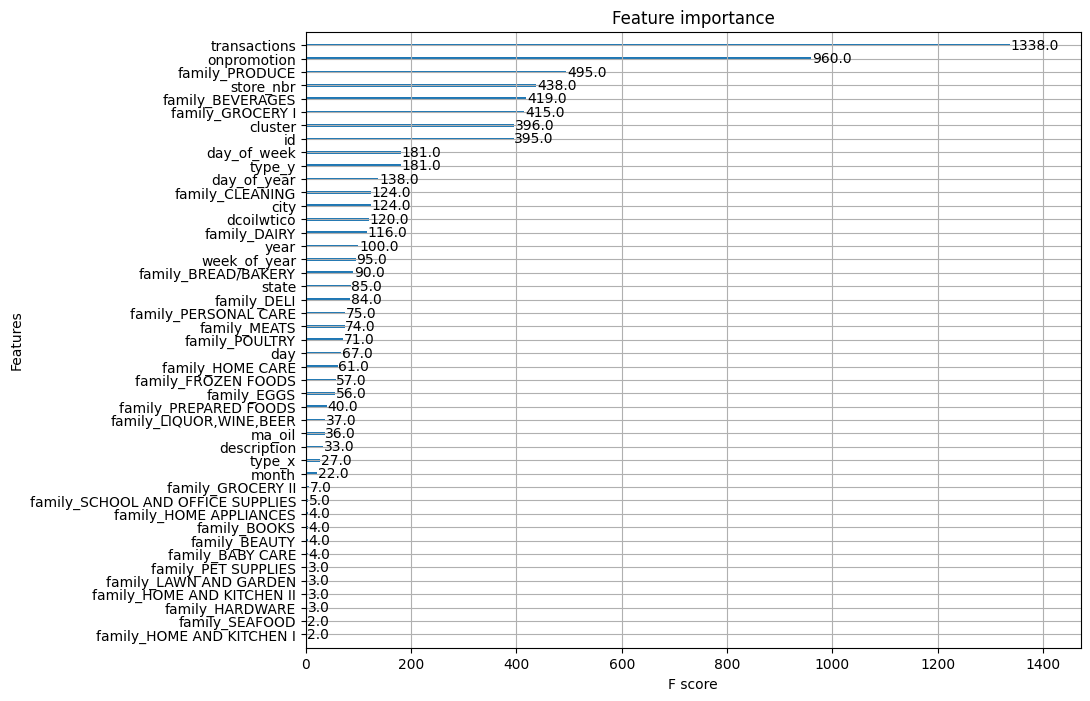

In [36]:
from xgboost import plot_importance
plot_importance(final_model)
plt.gcf().set_size_inches(10, 8)
plt.show()

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>

**Your tasks:**

Make some attempts to select relevant features. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it.

Throughout the project we have been finetunning our features. We have determined the features we have are the best features to use for right now. We have had problems with the amount of features and data that we have so we have spent a lot of time manipulating the data and creating features. Although we dont have the code for this because we have deleted all of the bad features and bad code.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods.
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

Note that we did hyperparameter optimization above with each model.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="11"></a>
<hr>

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models.
2. Summarize your observations.

Note that we showed feature importance and interpreted results under each model. XGBoost was our best model and the only one that beat Linear Regression. After much trial and error we found what we think is the best set of hyperparameters and features to include in the data set.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

**Your tasks:**

1. Try your best performing model on the test data (from train test split) and report test scores.
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias?
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

1. The XGBoost model is our best, it is already being trained on all the data, see section 8.
2. See below for answers to each subquestion
  - While its difficult to tell if our RMSLE scores and CV scores match up due to the nature of how they're calculated.  However, we can tell from the XGBoost model that the train and validation scores are very similar, this implies that we can trust that our model is acting consistenly.
  - Based on the RMSLE from kaggle for our best performing model of 1.8205 I would trust this score for predicting sales of a store.  It may not hit a low enough threshold to be used for more critical data but it does provide a baseline for future models/work to improve upon
  - Optimization bias is unlikely in this case.  This is because of what was mentioned earlier about RMSLE scores for training and validation being similar.
3. SHAP force plots for this model/dataset would be incredibely hard to read due the overwhelming amount of features that the model has.  Instead we've included above a graph of how much impact individual features had on the XGBoost model's predictions.

As you can see the transactions naturally had a huge impact on the ability to predict sales.  In hindsight this makes a lot of sense as transactions likely have a very high correlation to sales.  Shortly behind this the sales data around certain product families was a more surprising influentional factor.  Additionaly the onpromotion category played a huge factor in predicting sales data, this makes sense as items on promotion are more likely to sell.

See SHAP force plots below

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Submit the predictions to Kaggle <a name="13"></a>
<hr>

**Your tasks:**

Retrain the best model on the whole training dataset and upload the predicted output on the test set to Kaggle. Report your final test score.

In [41]:
# XGBoost is our best model and is already trained on the whole dataset

1.8205 is our final score on Kaggle from the XGBoost model results when trained on the entire dataset.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="14"></a>
<hr>

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  Discuss other ideas that you did not try but could potentially improve the performance/interpretability .

Some of our biggest takeaways come from the vast amount of feature engineering and data exploration we had to do.  There was a huge amount of data for this project and properly dealing with all that data was a huge undertaking for our team.  We all feel that we gained a lot of practical knowledge around machine learning in general but the feature engineering was the thing we learned the most about from this project.

Despite our best efforts there is just an overwhelming amount of data for this project.  We know that there is more work to be done in creating useful time series and other features from this data.  Additionally with more knowledge on the situation there may be features that would be better off dropped or ignored.  Additionally with more time we would love to be able to train more models that are more suitable for time series data.

<!-- END QUESTION -->

<br><br>